In [0]:
# Check if optional dependencies are installed
try:
    import matplotlib.pyplot as plt
    import pyarrow.parquet as pq
except ImportError:
    print('Optional dependencies are not installed. Please install them to run the performance tests.')

# Append parent directory to sys.path to allow importing stkde module
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent / 'src'))

# Import stkde module  
from stkde import calculate_stkde_for_voxel_grid

# Import other modules
import matplotlib.pyplot as plt
import numpy as np
import timeit

### Performance testing functions

In [0]:
def plot_time_performance_stkde_for_point_count(num_points_tests: list[int], seed:int=12345, print_titles:bool = True) -> None:
    
    # Set seed
    np.random.seed(seed)
    
    # Set bandwidths
    bw = 5.0
    
    # Create grids
    grid = np.linspace(0, 100, 100)
    
    # Create array to store the time results
    num_points_time_results = np.empty(len(num_points_tests), dtype=np.float64)
    for i, n in enumerate(num_points_tests):
        # Create random points
        points = np.random.rand(n, 3) * 100
        
        # Define a wrapper function for the calculation
        def wrapper():
            calculate_stkde_for_voxel_grid(points, bw, bw, bw, grid, grid, grid, False)
        
        # Run the wrapper function 3 times and take the average time
        times = timeit.repeat(wrapper, repeat=3, number=1)
        num_points_time_results[i] = np.mean(times)
        
    # Create matplotlib plot for the time results
    # Calculate trendline (linear)
    coefficients = np.polyfit(num_points_tests, num_points_time_results, 1)
    model = np.poly1d(coefficients)

    # Generate x-values for the trendline 
    trendline_x = np.linspace(min(num_points_tests), max(num_points_tests), 100)
    trendline_y = model(trendline_x)
    # Calculate the r^2 value
    residuals = num_points_time_results - model(num_points_tests)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((num_points_time_results - np.mean(num_points_time_results))**2)
    r_squared = 1 - (ss_res / ss_tot)
    

    # Create matplotlib plot for the time results
    plt.figure(figsize=(8,6))
    # Plot the trendline with high transparency
    plt.plot(trendline_x, trendline_y, color='blue', alpha=0.3, zorder=1, label=f't = {model[1]:.2e}n + {model[0]:.2e}. $R^2$ = {r_squared:.3f}')
    # Plot the scatter points
    plt.scatter(num_points_tests, num_points_time_results, color='blue', zorder=2, marker='x', label='STKDE running times')
    # Add labels and grid
    plt.xlabel('Number of points')
    plt.ylabel('Average time over 3 repetitions (s)')
    plt.grid()
    # Add titles
    if print_titles:
        plt.suptitle('Time to calculate STKDE for different number of points', fontsize=16)
        plt.title('For $100^3$ voxel grid, bandwidths of 5.0, random points from 0 to 100', fontsize=10)
    # Add legend
    plt.legend()
    if print_titles:
        plt.savefig(Path('output', 'point_count_stkde_plot.png'), bbox_inches='tight', dpi=300)
    else:
        plt.savefig(Path('output', 'point_count_stkde_plot_no_title.png'), bbox_inches='tight', dpi=300)
    # Show plot
    plt.show()
    plt.close()

In [0]:
def plot_time_performance_stkde_for_bandwidths(bandwidth_tests: list[float], seed:int=12345) -> None:
    
    # Set seed
    np.random.seed(seed)
    
    # Create random points
    points = np.random.rand(50000, 3) * 100
    
    # Create grids
    grid = np.linspace(0, 100, 100)
    
    # Extract first bandwidth (is used to adjust the bandwidths per dimension)
    first_bw = bandwidth_tests[0]
    
    # Create arrays to store the time results
    bandwidth_time_results_1 = np.empty(len(bandwidth_tests), dtype=np.float64)
    bandwidth_time_results_2 = np.empty(len(bandwidth_tests), dtype=np.float64)
    bandwidth_time_results_3 = np.empty(len(bandwidth_tests), dtype=np.float64)
    
    # Create a helper function to measure time for different bandwidths configurations
    def measure_time(bw_x, bw_y, bw_z):
        def wrapper():
            calculate_stkde_for_voxel_grid(points, bw_x, bw_y, bw_z, grid, grid, grid, False)
        return np.mean(timeit.repeat(wrapper, repeat=3, number=1))
    
    for i, bw in enumerate(bandwidth_tests):
        # Measure times for different bandwidth configurations
        bandwidth_time_results_1[i] = measure_time(bw, first_bw, first_bw)
        bandwidth_time_results_2[i] = measure_time(bw, bw, first_bw)
        bandwidth_time_results_3[i] = measure_time(bw, bw, bw)
        
            
    # Create matplotlib plot for the time results
    plt.figure(figsize=(8,6))
    plt.scatter(bandwidth_tests, bandwidth_time_results_1, color='green', marker='x', label='1')
    plt.scatter(bandwidth_tests, bandwidth_time_results_2, color='green', marker='o', label='2')
    plt.scatter(bandwidth_tests, bandwidth_time_results_3, color='green', marker='^', label='3')
    plt.xlabel("Bandwidths' size")
    plt.ylabel('Average time over 3 repetitions (s)')
    plt.grid()
    plt.legend(title='Number of changing bandwidths', alignment='left')
    plt.suptitle('Time to calculate STKDE for different bandwidths', fontsize=16)
    plt.title('For $100^3$ voxel grid, 50000 random points from 0 to 100', fontsize=10)
    plt.savefig(Path('output', 'bandwidth_stkde_plot.png'), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

In [0]:
def plot_time_performance_for_grid_size(grid_size_tests: list[int], seed:int=12345) -> None:
    
    # Set seed
    np.random.seed(seed)
    
    # Create random points
    points = np.random.rand(50000, 3) * 100
    
    # Set bandwidths
    bw = 5.0
    
    # Create arrays to store the time results
    grid_size_time_results_1 = np.empty(len(grid_size_tests), dtype=np.float64)
    grid_size_time_results_2 = np.empty(len(grid_size_tests), dtype=np.float64)
    grid_size_time_results_3 = np.empty(len(grid_size_tests), dtype=np.float64)
    
    # Create a helper function to measure time for different grid sizes
    def measure_time(grid_x, grid_y, grid_t):
        def wrapper():
            calculate_stkde_for_voxel_grid(points, bw, bw, bw, grid_x, grid_y, grid_t, False)
        return np.mean(timeit.repeat(wrapper, repeat=3, number=1))
    
    # Create standard grid
    standard_grid = np.linspace(0, 100, grid_size_tests[0])
    
    for i, grid_size in enumerate(grid_size_tests):
        # Create altered grid
        altered_grid = np.linspace(0, 100, grid_size)
        
        # Measure times for different grid sizes
        grid_size_time_results_1[i] = measure_time(altered_grid, standard_grid, standard_grid)
        grid_size_time_results_2[i] = measure_time(altered_grid, altered_grid, standard_grid)
        grid_size_time_results_3[i] = measure_time(altered_grid, altered_grid, altered_grid)
        
    # Create matplotlib plot for the time results
    plt.figure(figsize=(8,6))
    plt.scatter(grid_size_tests, grid_size_time_results_1, color='green', marker='x', label='1')
    plt.scatter(grid_size_tests, grid_size_time_results_2, color='green', marker='o', label='2')
    plt.scatter(grid_size_tests, grid_size_time_results_3, color='green', marker='^', label='3')
    plt.xlabel("Grid size")
    plt.ylabel('Average time over 3 repetitions (s)')
    plt.grid()
    plt.legend(title='Number of changing sides for grid', alignment='left')
    plt.suptitle('Time to calculate STKDE for different grid sizes', fontsize=16)
    plt.title('For 50000 random points from 0 to 100, with bandwidth 5.0', fontsize=10)
    plt.savefig(Path('output', 'grid_size_stkde_plot.png'), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

### Run performance tests

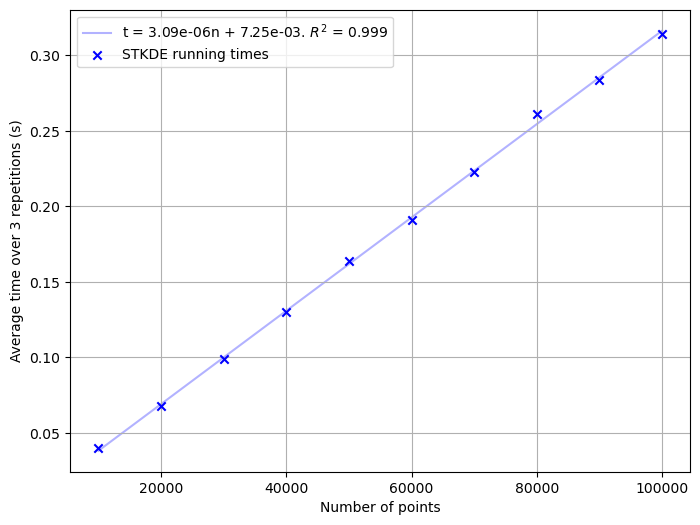

In [0]:
plot_time_performance_stkde_for_point_count([10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000], print_titles=False)

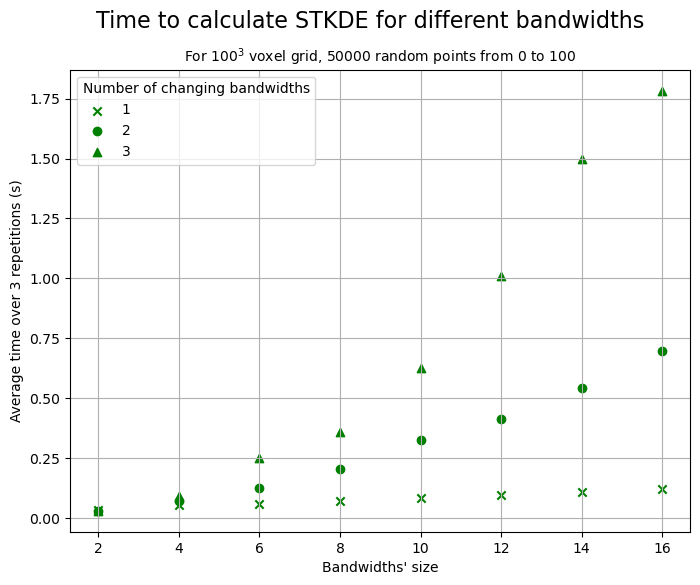

In [0]:
plot_time_performance_stkde_for_bandwidths([2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0])

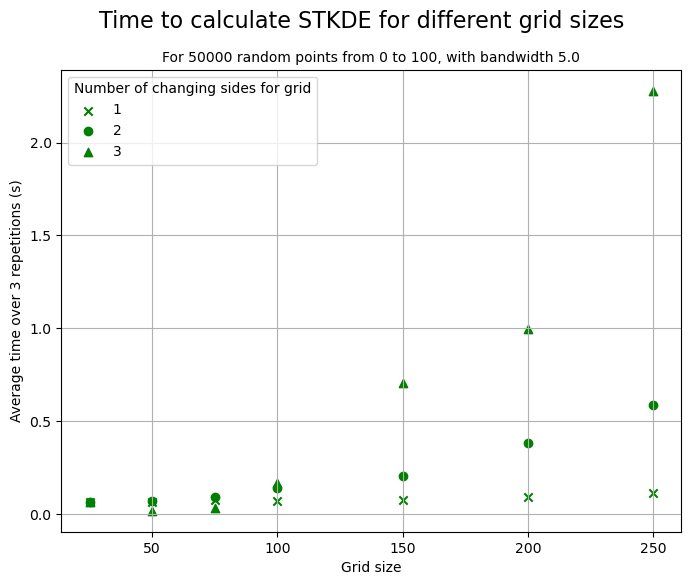

In [0]:
plot_time_performance_for_grid_size([25, 50, 75, 100, 150, 200, 250])